# Employee Retention

### 1-1-2017

## Problem Statement
We got employee data from a few companies. We have data about all employees who joined
from 2011/01/24 to 2015/12/13. For each employee, we also know if they are still at the
company as of 2015/12/13 or they have quit. Beside that, we have general info about the
employee, such as avg salary during her tenure, dept, and yrs of experience.
As said above, the goal is to predict employee retention and understand its main drivers.
Specifically, you should:  

--Assume, for each company, that the headcount starts from zero on 2011/01/23. Estimate
employee headcount, for each company, on each day, from 2011/01/24 to 2015/12/13.
That is, if by 2012/03/02 2000 people have joined company 1 and 1000 of them have
already quit, then company headcount on 2012/03/02 for company 1 would be 1000.  
----You should create a table with 3 columns: day, employee_headcount, company_id.  
--What are the main factors that drive employee churn? Do they make sense? Explain your
findings.  
--If you could add to this data set just one variable that could help explain employee churn,
what would that be?

## Data Description

Columns:  
--employee_id : id of the employee. Unique by employee per company  
--company_id : company id.  
--dept : employee dept  
--seniority : number of yrs of work experience when hired  
--salary: avg yearly salary of the employee during her tenure within the company  
--join_date: when the employee joined the company, it can only be between 2011/01/24
and 2015/12/13  
--quit_date: when the employee left her job (if she is still employed as of 2015/12/13, this
field is NA)  

# Part 0 - Setup, Import, Exploration

Before any complex analysis, let's perform some exploratory analysis and sanity checks to ensure our data makes sense.

In [1]:
# setup and import
## basics
import pandas as pd
import numpy as np
from pandas import DataFrame, Series

## date manipulation
from dateutil.parser import parse

## plotting
import matplotlib.pyplot as plt
%pylab inline

## formulas
import patsy

Populating the interactive namespace from numpy and matplotlib


In [2]:
# grab the data and store as dataframe
emps = pd.read_csv('employee_retention_data.csv')

In [3]:
# let's look at the first few rows
emps.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [4]:
# let's check for blank values in each column
def fillprc(dff):
    fillprc = [] # initialize empty list to be returned later
    dfcols = list(dff.columns.values) # get list of all column names
    for i in range(0,len(dfcols)): # loop through each column and get percentage filled, defined as ratio of lengths
        colname = dfcols[i]
        collfillprc = float(dff[dfcols[i]].value_counts().sum())/dff[dfcols[i]].value_counts(dropna=False).sum()
    
        fillprc.append((colname,collfillprc)) # add tuple of colname and percentage filled to list
     
    missinglist = [f for f in fillprc if f[1] != 1] # Filter fillprc list for less than 100%

    return missinglist

In [5]:
fillprc(emps)
# here we see that only the quit_date column has any blanks - this is great and these blanks represent employees who were
# still employed as of Dec 13, 2015

[('quit_date', 0.5469192777912719)]

In [6]:
# check for duplicate rows
(len(emps.drop_duplicates())*1.0)/len(emps)
# a value of 1.0 means the length of the de-duplicated list is the same as the original list, implying no duplicate value

1.0

In [7]:
# let's check for duplicate values in employee ID
(len(Series(emps['employee_id'].values).unique())*1.0)/len(emps['employee_id'].values)
# a value of 1.0 means the length of the de-duplicated list is the same as the original list, implying no duplicate value, so
# employee_id is in fact a unique identifier

1.0

In [8]:
# let's look at data types to ensure they make sense
emps.dtypes
# they all make sense! later, we will need to convert the date objects to dates but they are ok for now

employee_id    float64
company_id       int64
dept            object
seniority        int64
salary         float64
join_date       object
quit_date       object
dtype: object

In [9]:
# let's examine values for each field to see if anything is odd

In [10]:
# first let's view the numerical variables
emps.describe()
# everything looks reasonable except a max seniority of 99 years - this is likely a fill-in value - we'll handle this later

,employee_id,company_id,seniority,salary
count,24702.000000,24702.000000,24702.000000,24702.000000
mean,501604.403530,3.426969,14.127803,138183.345478
std,288909.026101,2.700011,8.089520,76058.184573
min,36.000000,1.000000,1.000000,17000.000000
25%,250133.750000,1.000000,7.000000,79000.000000
50%,500793.000000,2.000000,14.000000,123000.000000
75%,753137.250000,5.000000,21.000000,187000.000000
max,999969.000000,12.000000,99.000000,408000.000000


In [11]:
emps['dept'].value_counts()
# looks reasonable

customer_service    9180
engineer            4613
data_science        3190
sales               3172
marketing           3167
design              1380
Name: dept, dtype: int64

In [12]:
emps['company_id'].value_counts()
# reasonable, but we will need to be wary about any conclusions drawn regarding companies 11 and 12 since there are so 
# few observations

1     8486
2     4222
3     2749
4     2062
5     1755
6     1291
7     1224
8     1047
9      961
10     865
12      24
11      16
Name: company_id, dtype: int64

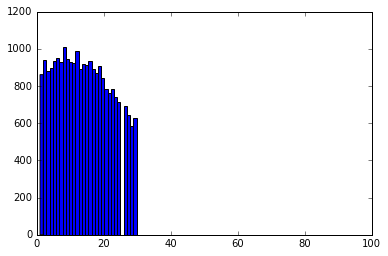

In [13]:
plt.hist(emps['seniority'],bins='auto')
plt.show()
# looks like the range goes way beyond what we would expect - we know the max seniority is 99 years so we lilely have some errors

In [14]:
emps['seniority'].value_counts()
# there are two outlier observations with seniority values of 99 and 98 - let's take a closer look

8     1008
12     988
6      950
9      944
2      942
16     936
5      936
7      928
10     927
11     924
14     920
15     911
19     910
4      895
13     894
17     893
3      881
18     872
1      861
20     844
23     785
21     782
22     764
24     743
25     715
26     694
27     642
29     626
28     585
99       1
98       1
Name: seniority, dtype: int64

In [15]:
emps[emps['seniority'] > 29]
# here we see the two employees with odd tenures - we only have two, so let's just drop them since we have over 20k rows of data

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
24700,97289.0,10,engineer,98,266000.0,2011-12-13,2015-01-09
24701,604052.0,1,marketing,99,185000.0,2011-07-26,2013-12-06


In [16]:
# remove two observations with seniority greater than 29
emps = emps[emps['seniority'] <= 29]

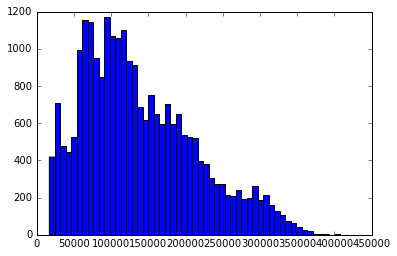

In [17]:
plt.hist(emps['salary'],bins='auto')
plt.show()
# this looks reasonable and fairly log-normal, maybe a log transformation will be useful later if we are using as a predictor?

At this point, we have established that our variables are distributed as expected and we have dropped two outlier values so our data is slightly cleaner. Next, let's perform some exploratory analysis around the question we are asking - how can we understand and predict employee retention?

### Dependent Variable

First, let's create a couple of variables to better analyze churn and retention. First, let's create an indicator variable to determine if the employee has quit (1) or is still with the company (0). Next, we need a measure of the length of time the employee has been with the company. If the employee has quit, then the time will be equal to the quit date minus the join date. If the employee is still employed, the time will be join date minus "today" (2015/12/13). 

In [18]:
# define variable as boolean to check if quit_date is filled or not. If filled, then the employee has churned. 
emps['churn'] = emps['quit_date'].isnull() == False

In [19]:
# define time variable
## first, we need to convert the date fields to date values
from dateutil.parser import parse
from datetime import timedelta

In [20]:
# convert dates to get duration
## convert join date without issue
emps['join_date'] = emps['join_date'].map(lambda x: parse(str(x)))

## create max time as either quit date or 12/13/2015 if quit date is NA, convert to date object
emps['max_time'] = emps['quit_date'].fillna('2015-12-13')
emps['max_time'] = emps['max_time'].map(lambda x: parse(str(x)))

# create duration as difference between max time and join date, then convert to count of days
emps['duration'] = emps['max_time'] - emps['join_date']
emps['duration'] = emps['duration'].map(lambda x: x.days)

In [21]:
emps.head()
# looks good!

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,churn,max_time,duration
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,True,2015-10-30,585
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,True,2014-04-04,340
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN,False,2015-12-13,426
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,True,2013-06-07,389
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,True,2014-08-22,1040


In [22]:
emps['churn'].value_counts()
## looks like slightly over half of our employees have quit - reasonable proportions if we want to go the binary
## classification route

True     13508
False    11192
Name: churn, dtype: int64

In [23]:
# how does retention vary across company?
ret_comp = pd.crosstab(emps['company_id'],emps['churn'])
ret_comp['retprc'] = ret_comp[0]/(1.0*ret_comp[0]+ret_comp[1])
ret_comp
## retention is near 45% for all companies except 11 and 12, but we already decided to be wary of conclusions drawn from so 
## few observations

churn,False,True,retprc
company_id,,,
1,3865,4620,0.455510
2,2016,2206,0.477499
3,1218,1531,0.443070
4,909,1153,0.440834
5,772,983,0.439886
6,579,712,0.448490
7,532,692,0.434641
8,468,579,0.446991
9,432,529,0.449532


In [24]:
# how does retention vary across department?
dep_comp = pd.crosstab(emps['dept'],emps['churn'])
dep_comp['retprc'] = dep_comp[0]/(1.0*dep_comp[0]+dep_comp[1])
dep_comp
## we see some small differences here - engineers and data scientists are less likely to churn than sales or marketing, so
## hopefully we will see these variables as significant when we predict. however, we have not controlled for any other 
## variables, but so far, it looks like I made the right career choice!

churn,False,True,retprc
dept,,,
customer_service,4086,5094,0.445098
data_science,1508,1682,0.472727
design,602,778,0.436232
engineer,2251,2361,0.488075
marketing,1384,1782,0.437145
sales,1361,1811,0.429067


In [25]:
# how does retention vary across salary?
emps['salary_bucket'] = pd.qcut(emps['salary'],10) # create ten percentile-based buckets to analyze more easily
comp_comp = pd.crosstab(emps['salary_bucket'],emps['churn'])
comp_comp['retprc'] = comp_comp[0]/(1.0*comp_comp[0]+comp_comp[1])
comp_comp
## again, we see some differences across salary buckets in retention percentage, such as the highest and lowest buckets of salary
## churning at a lower rate than elsewhere. we cannot draw conclusions without controlling for other variables, but this is 
## encouraging

churn,False,True,retprc
salary_bucket,,,
"[17000, 52000]",1267,1205,0.512540
"(52000, 70000]",1165,1377,0.458301
"(70000, 89000]",1134,1387,0.449821
"(89000, 105000]",1006,1356,0.425910
"(105000, 123000]",1064,1517,0.412243
"(123000, 145000]",931,1447,0.391505
"(145000, 172000]",1008,1435,0.412607
"(172000, 202000]",1064,1398,0.432169
"(202000, 250000]",1162,1326,0.467042


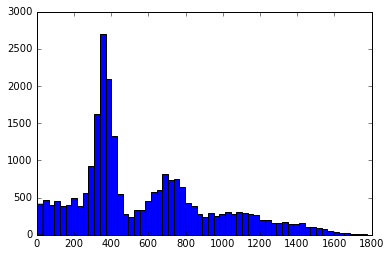

In [26]:
# let's look at duration in some detail
plt.hist(emps['duration'],bins='auto')
plt.show()
## looks like a bimodal distribution with peaks around 1 year and 2 years (365 and 730 days). People tend to leave jobs after 
## bonus cycles, so it makes sense 

## Part 1
--Assume, for each company, that the headcount starts from zero on 2011/01/23. Estimate employee headcount, for each company, on each day, from 2011/01/24 to 2015/12/13. That is, if by 2012/03/02 2000 people have joined company 1 and 1000 of them have already quit, then company headcount on 2012/03/02 for company 1 would be 1000.  
----You should create a table with 3 columns: day, employee_headcount, company_id.  
  
To tackle this problem, we will initialize a series of all dates from 1/23/2011 to 12/13/2015. Then, for each company, we will use a pivot table to get counts of adds (from *join_date*) and subtracts (from *quit_date*) for each date. We will then join both of these series to our list of all dates, filling missing values with zero, and then take the difference to find the net headcount change each day. From this field we can then use a cumulative sum to find headcount on each day.

In [27]:
# create dataframe indexed by the date range
datelist = pd.DataFrame(index=pd.date_range(start='2011-01-23',end='2015-12-13').tolist())

In [28]:
datelist.head()

""
2011-01-23
2011-01-24
2011-01-25
2011-01-26
2011-01-27


In [29]:
# get list of all unique company IDs to later iterate through
complist = emps['company_id'].unique().tolist()

# initialize empty DF with the three columns we care about
headcounts = pd.DataFrame(columns=['day','company_id','employee_headcount'])

# loop through each unique company ID and do the following:
for i in complist:
    # create temporary DF of just the company ID we want to examine
    emps_c = emps[emps['company_id'] == i]

    # create pivot tables to count adds and quits on each date, use employee_id as value since it's always filled
    adds = pd.DataFrame(pd.pivot_table(data=emps_c,values='employee_id',index='join_date',aggfunc='count',fill_value=0))
    quits = pd.DataFrame(pd.pivot_table(data=emps_c,values='employee_id',index='quit_date',aggfunc='count',fill_value=0))

    # merge adds and quits onto our datelist, use left join so we keep all dates in our series
    deltas = datelist.merge(adds,how='left',left_index=True,right_index=True)
    deltas = deltas.merge(quits,how='left',left_index=True,right_index=True)

    # rename columns
    deltas = deltas.rename(columns={'employee_id_x':'joins','employee_id_y':'quits'})

    # fill blank values with zero, since a missing value means no employees joined or quit that day
    # this isn't strictly necessary but helps for interpretability
    deltas['joins'] = deltas['joins'].fillna(0)
    deltas['quits'] = deltas['quits'].fillna(0)

    # create net column to find change in headcount each day
    deltas['net'] = deltas['joins'] - deltas['quits']

    # create headcount as cumulative sum
    deltas['employee_headcount'] = deltas['net'].cumsum(axis=0)
    
    # add company ID field
    deltas['company_id'] = i
    
    # add day field equal to index
    deltas['day'] = deltas.index
    
    # cut down to columns we care about - note column names are the same as our final DF
    deltas = deltas[['day','company_id','employee_headcount']]
    
    # add to headcount  final DF
    headcounts = headcounts.append(deltas,ignore_index=True)

In [30]:
# let's take a look
headcounts.head()
# this appears to have what we're after!

,day,company_id,employee_headcount
0,2011-01-23,7.0,0.0
1,2011-01-24,7.0,1.0
2,2011-01-25,7.0,1.0
3,2011-01-26,7.0,1.0
4,2011-01-27,7.0,1.0


In [31]:
# let's look at a spot in the middle to see if it makes sense
headcounts[4747:4767]
# this passes the sanity check! looks like company 2 had a mass exodus of 18 people on 4/25/2014 - let's double check

,day,company_id,employee_headcount
4747,2014-04-12,2.0,1780.0
4748,2014-04-13,2.0,1780.0
4749,2014-04-14,2.0,1803.0
4750,2014-04-15,2.0,1803.0
4751,2014-04-16,2.0,1804.0
4752,2014-04-17,2.0,1805.0
4753,2014-04-18,2.0,1805.0
4754,2014-04-19,2.0,1805.0
4755,2014-04-20,2.0,1805.0
4756,2014-04-21,2.0,1808.0


In [32]:
# this line will tell us how many employees quit company 2 on 4/25/2014. It should be 18, since headcount in our final DF
# drops by 18 on this day
len(emps[(emps['company_id'] == 2.0) & (emps['quit_date'] == '2014-04-25')])
# correct!

18

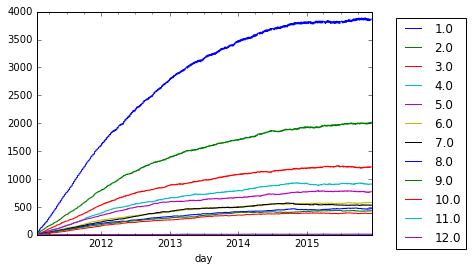

In [35]:
# let's take a quick look graphically to see how it looks
headcounts.pivot(index='day', columns='company_id', values='employee_headcount').plot()
plt.legend(bbox_to_anchor=(1.3, 1, 0, 0))
plt.show()
# looks good!

Above we were able to create a dataframe that shows headcount by day for each company that shows increasing headcount over time from 2011 to 2015. Headcount is steadily increasing for each company and starts to flatten towards the end. However, this does not help us to understand what factors lead to employee churn, which we will explore below.

## Part 2
--What are the main factors that drive employee churn? Do they make sense? Explain your
findings.  
--If you could add to this data set just one variable that could help explain employee churn,
what would that be?

To answer these questions, we want to develop some sort of predictive model that identifies which features of a given employee - salary, seniority, etc. - increase or decrease the likelihood of churning in the observed time period. The model framework that makes the most sense in this case is survival analysis, where we treat churn as the survival event. We can apply a Cox Regression (proportional hazards model) to identify relevant predictors from our independent variables. This model's assumptions fit our data relatively well in that most observed independent variables do not change significantly over time (department, seniority, etc. are fixed and salary likely only grows incrementally unless there is a promotion), and that the effect a given variable has on likelihood of survival/churn does not change over time. The second assumption may not necessarily be true over long time horizons - for example, the effect of a lower salary may have a greater effect on retention after a tenure of 5-10 years compared to an employee who just joined. However, over just a few years, this assumption is reasonable.

To identify the factors that influence churn, we will use the survival analysis package in R and examine the effect of different variables. Since we are not looking at out-of-sample prediction, but rather variance explained in-sample, we will look at likelihood statistics to evaluate model fits and determine if variables are useful.

We will use export our *emps* dataframe to R, run survival analysis in R, and examine those results.

In [36]:
# double check we have what we need
emps.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,churn,max_time,duration,salary_bucket
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,True,2015-10-30,585,"(70000, 89000]"
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,True,2014-04-04,340,"(172000, 202000]"
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN,False,2015-12-13,426,"(89000, 105000]"
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,True,2013-06-07,389,"(105000, 123000]"
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,True,2014-08-22,1040,"(250000, 408000]"


### R for Survival Analysis

In [37]:
%load_ext rpy2.ipython

In [38]:
%%R 
options(width=300)
# get the survival package if you do not have it:
if (! length(which(.packages(all.available=TRUE) %in% "survival"))) {
    install.packages("survival",repos="http://cran.cnr.berkeley.edu/")
}
# load survival package
library(survival)

In [39]:
%R -i emps # send emps DF to the R workspace
%R attach(emps)
%R print(head(emps)) # make sure it looks ok

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,churn,max_time,duration,salary_bucket
0,13021.0,7,customer_service,28,89000.0,1.395637e+09,2015-10-30,1,1.446181e+09,585,"(70000, 89000]"
1,825355.0,7,marketing,20,183000.0,1.367212e+09,2014-04-04,1,1.396588e+09,340,"(172000, 202000]"
2,927315.0,4,marketing,14,101000.0,1.413176e+09,nan,0,1.449986e+09,426,"(89000, 105000]"
3,662910.0,7,customer_service,20,115000.0,1.336972e+09,2013-06-07,1,1.370581e+09,389,"(105000, 123000]"
4,256971.0,2,data_science,23,276000.0,1.318828e+09,2014-08-22,1,1.408684e+09,1040,"(250000, 408000]"
5,509529.0,4,data_science,14,165000.0,1.327903e+09,2013-08-30,1,1.377839e+09,578,"(145000, 172000]"


In [51]:
%%R
# let's try a cox survival regression with just seniority as a predictor
reg1 = coxph(Surv(duration,churn) ~ seniority, emps)
# this creates a survival object using duration and churn, first regress on seniority and store the summary as an object
sum1 = summary(reg1)

# try model with all of our variables
reg2 = coxph(Surv(duration,churn) ~ seniority + salary + factor(company_id) + dept, emps)
sum2 = summary(reg2)

In [52]:
%R -o sum1
print sum1
# let's look at a summary of the first cox regression

Call:

coxph(formula = Surv(duration, churn) ~ seniority, data = emps)



  n= 24700, number of events= 13508 



                coef  exp(coef)   se(coef)      z Pr(>|z|)

seniority -0.0001955  0.9998045  0.0010601 -0.184    0.854



          exp(coef) exp(-coef) lower .95 upper .95

seniority    0.9998          1    0.9977     1.002



Concordance= 0.5  (se = 0.003 )

Rsquare= 0   (max possible= 1 )

Likelihood ratio test= 0.03  on 1 df,   p=0.8536

Wald test            = 0.03  on 1 df,   p=0.8536

Score (logrank) test = 0.03  on 1 df,   p=0.8536





The proportional hazards model does not yield a significant variable on seniority when no other variables are included, shown by the very large p-value of .935. In addition, the p-values from the likelihood ratio and Wald tests indicate that we should not reject the null hypoethesis of nonsignificance of the model. That is to say, this model is fairly worthless.

In [53]:
%R -o sum2
print sum2
# let's look at the second regression including seniority, salary, company, and department

Call:

coxph(formula = Surv(duration, churn) ~ seniority + salary + 

    factor(company_id) + dept, data = emps)



  n= 24700, number of events= 13508 



                           coef  exp(coef)   se(coef)      z Pr(>|z|)    

seniority             1.029e-02  1.010e+00  1.727e-03  5.956 2.58e-09 ***

salary               -1.801e-06  1.000e+00  2.572e-07 -7.005 2.47e-12 ***

factor(company_id)2  -5.649e-02  9.451e-01  2.589e-02 -2.182  0.02910 *  

factor(company_id)3   4.027e-03  1.004e+00  3.040e-02  0.132  0.89462    

factor(company_id)4   1.584e-02  1.016e+00  3.372e-02  0.470  0.63860    

factor(company_id)5  -2.031e-02  9.799e-01  3.591e-02 -0.565  0.57179    

factor(company_id)6  -1.593e-02  9.842e-01  4.091e-02 -0.389  0.69705    

factor(company_id)7  -3.030e-02  9.702e-01  4.134e-02 -0.733  0.46364    

factor(company_id)8  -8.902e-03  9.911e-01  4.478e-02 -0.199  0.84242    

factor(company_id)9  -2.656e-02  9.738e-01  4.645e-02 -0.572  0.56749    

factor(company_id)

In [55]:
%R test2 = cox.zph(reg2) # here we are going to test the proportional hazards assumption of our model fit
%R -o test2
print test2

                           rho    chisq        p

seniority            -0.030214 1.22e+01 4.86e-04

salary                0.039334 1.97e+01 9.01e-06

factor(company_id)2  -0.000655 5.80e-03 9.39e-01

factor(company_id)3   0.013418 2.43e+00 1.19e-01

factor(company_id)4   0.003642 1.79e-01 6.72e-01

factor(company_id)5   0.004903 3.23e-01 5.70e-01

factor(company_id)6  -0.001904 4.87e-02 8.25e-01

factor(company_id)7   0.000646 5.62e-03 9.40e-01

factor(company_id)8  -0.005922 4.75e-01 4.91e-01

factor(company_id)9   0.006415 5.54e-01 4.57e-01

factor(company_id)10  0.000172 3.98e-04 9.84e-01

factor(company_id)11  0.002499 8.44e-02 7.71e-01

factor(company_id)12 -0.004738 3.04e-01 5.82e-01

deptdata_science     -0.010323 1.42e+00 2.33e-01

deptdesign           -0.001745 4.04e-02 8.41e-01

deptengineer         -0.017038 3.92e+00 4.76e-02

deptmarketing        -0.014211 2.66e+00 1.03e-01

deptsales            -0.023695 7.38e+00 6.59e-03

GLOBAL                      NA 4.33e+01 7.14e-04



These results are much better! Overall, the p-values of the likelihood ratio and Wald tests indicate that this model is statistically significant. Looking at the model coefficients, we see strong statistical significance for the *salary*, *seniority*, and marketing and sales department variables, and minor statistical significance for company 2 as well as the design department.  

Looking at the exponentiated coefficients, which reflect the multiplicative effect of the variable on the hazard rate - the churn likelihood - of a given employee, only two have a value that differs significantly from one. These are indicator variables for the marketing and sales departments, both compared to the base case of the customer service department. The values are 1.12 for marketing and 1.17 for sales, meaning that the churn likelihood of a given employee increases by 12% and 17%, respectively, compared to a customer service employee.  

However, when we test the proportional hazards assumption, which is key to the model, we see that *seniority*, *salary*, and the sales department variables all violate the assumption. This means that we cannot make any meaningful conclusions about these variables or use them for prediction, which is not satisfying.  

To get another view of the data, we will run similar regressions predicting *duration* and the probability of churn using OLS and logistic regression and examine the coefficients and their significance. Again, these regressions will be used as a descriptive tool to explain the relationship between independent and dependent variables, rather than for predictive purposes. When predicting *duration*, results will be biased since the data is right-censored and there is a maximum value for duration. We run into the same issue when predicting churn probability because we do not know, for example, if an employee is going to quit on 12/24/15, the first day after our observed data ends. Nevertheless, a regression will allow us to look within the dataset to see which variables are correlated with a longer tenure at the companies and which increase the likelihood of quitting in the observed window.

In [82]:
# import feaure selection packages
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import f_classif

# import regression packages
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

In [66]:
# create formulas for predicting duration and churn
d_model = 'duration ~ seniority + salary + C(company_id) + dept'
c_model = 'churn ~ seniority + salary + C(company_id) + dept'

# create dataframes from formulas using patsy
y_c,x_c = patsy.dmatrices(c_model,emps,return_type='dataframe')
del y_c['churn[False]'] # delete column for churn = false since patsy does not interpret booleans
y_d,x_d = patsy.dmatrices(d_model,emps,return_type='dataframe')

In [83]:
# run feature selection regression on duration model
feat_d = f_regression(x_d, y_d)
fit_d = LinearRegression()
fit_d.fit(x_d,y_d)

# create DF to store coefficients and p-values
r2 = DataFrame(data=fit_d.coef_[0],index=x_d.columns.values,columns=['coefficient'])
r2['pval'] = feat_d[1]
r2['sig'] = r2['pval'] <= .01

# show results
r2

,coefficient,pval,sig
Intercept,0.000000,NaN,False
C(company_id)[T.2],5.228873,4.233057e-02,False
C(company_id)[T.3],-0.689028,1.296118e-01,False
C(company_id)[T.4],-2.462233,1.524884e-01,False
C(company_id)[T.5],5.728065,6.196648e-01,False
C(company_id)[T.6],2.565123,4.591815e-01,False
C(company_id)[T.7],17.154424,3.978644e-01,False
C(company_id)[T.8],-2.019879,3.360459e-01,False
C(company_id)[T.9],2.291902,6.501625e-01,False
C(company_id)[T.10],4.054267,7.016914e-01,False


When predicting duration using a linear model, we see that similar variables are significant: the data science, engineering, and sales departments (compared to the base case of customer service), as well as *salary*. Interestingly, all of the departmental indicators have negative coefficients, meaning that they all reduce the employee's duration compared to customer service. However, since the data is right-censored, we cannot conclude that these employees leave earlier. It could be the case, for example, that the data science departments are brand new at most companies and these employees simply were hired more recently. The coefficient on *salary* is highly significant, with a positive value, indicating that higher salaried employees stay longer. This confirms what we saw in the earlier pivot tables, with employee retention higher at the top and bottom ends of salary ranges. 

In [84]:
# run feature selection classifier on churn model
feat_c = f_classif(x_c, y_c)
fit_c = LogisticRegression()
fit_c.fit(x_c,y_c)

# create DF to store coefficients and p-values
r2 = DataFrame(data=fit_c.coef_[0],index=x_c.columns.values,columns=['coefficient'])
r2['pval'] = feat_c[1]
r2['sig'] = r2['pval'] <= .01

# show results
r2

,coefficient,pval,sig
Intercept,1.056672e-11,NaN,False
C(company_id)[T.2],3.610472e-13,4.732803e-04,True
C(company_id)[T.3],1.596178e-12,2.616515e-01,False
C(company_id)[T.4],1.255915e-12,2.418563e-01,False
C(company_id)[T.5],1.089206e-12,2.479845e-01,False
C(company_id)[T.6],6.618994e-13,7.315195e-01,False
C(company_id)[T.7],8.465103e-13,1.828752e-01,False
C(company_id)[T.8],5.540099e-13,6.840851e-01,False
C(company_id)[T.9],4.744989e-13,8.198337e-01,False
C(company_id)[T.10],4.739145e-13,6.514655e-01,False


Looking at a model that predicts the probability of churning, similar variables are significant at the 1% level: company 2, engineering, and sales indicators, and *salary*. Other than engineering, the coefficients are all positive, indicating their presence increases the likelihood of churning in the observed time period. We saw that employees in the sales department are retained at a lower rate, so this makes sense. However, we also observed that higher salaried employees tend to stick around, which is the opposite of the result observed here. It could be that the large number of employees in the middle salary range - who churn at rates above the top and bottom ends of salary - could be forcing the coefficient to a positive value. To confirm, let's swap the *salary* variable for *salary_bucket* and compare the results again.

In [85]:
# define new formula with salary bucket instead of salary
c_model2 = 'churn ~ seniority + salary_bucket + C(company_id) + dept'

# create dataframes from formulas using patsy
y_c,x_c = patsy.dmatrices(c_model2,emps,return_type='dataframe')
del y_c['churn[False]'] # delete column for churn = false since patsy does not interpret booleans

# run feature selection classifier on churn model
feat_c = f_classif(x_c, y_c)
fit_c = LogisticRegression()
fit_c.fit(x_c,y_c)

# create DF to store coefficients and p-values
r2 = DataFrame(data=fit_c.coef_[0],index=x_c.columns.values,columns=['coefficient'])
r2['pval'] = feat_c[1]
r2['sig'] = r2['pval'] <= .01

# show results
r2

,coefficient,pval,sig
Intercept,-0.014380,NaN,False
"salary_bucket[T.(52000, 70000]]",0.224751,5.794206e-01,False
"salary_bucket[T.(70000, 89000]]",0.295954,7.257349e-01,False
"salary_bucket[T.(89000, 105000]]",0.382340,5.218173e-03,True
"salary_bucket[T.(105000, 123000]]",0.465559,1.039523e-05,True
"salary_bucket[T.(123000, 145000]]",0.567137,2.136445e-10,True
"salary_bucket[T.(145000, 172000]]",0.472649,2.256934e-05,True
"salary_bucket[T.(172000, 202000]]",0.429016,2.776359e-02,False
"salary_bucket[T.(202000, 250000]]",0.298422,1.412192e-01,False
"salary_bucket[T.(250000, 408000]]",-0.069085,3.332805e-33,True


Using salary buckets instead of salary as a continuous variable, we see our initial observations confirmed. For the salary bucket variable, the base case is the lowest salary bucket, which we observed to have a lower churn rate than the middle salary range, but not quite as low as the highest salary range. The middle buckets - representing 89k to 172k - are all signifcant with positive coeffients, indicating they increase the likelihood of churn. The highest salary bucket is also significant, with a negative coefficient, indicating that churn is less likely for these employees than even the low-churning bottom salary range. Other conclusions remain the same.

## Conclusion

Overall, we see that two variables play the largest role in affecting churn: department and, more importantly, salary. Employees in the middle salary range are more likely to churn and have lower employment durations (in our observed window) than employees at the low or high end. There could be a few causes for this. The employees with the lowest wages may be have the least experience, and so even if they are not fundamentallly different than other employees, they may be less inclined to leave their job for another. Or, they may be of a lower ability and less marketable, so have fewer exit opportunities. Conversely, on the high end, employees that are well-compensated need extraordinary motivation to leave, so it makes sense they churn at a lower rate. The middle range represents typical employees in the middle of their careers and on the lookout for new opportunities - unless they are data scientists! We also see that across departments, there is some variance in churn and retention. The marketing and sales departments churn at a higher rate than engineers or data scientists. 

If we were to add another variable, it would certainly be related to salary since that appears to be the variable that affects churn the most. For example, the salary a given employee was paid at a previous job would allow us to better determine if their current job is a major upgrade (probably less likely to churn) or more of a lateral move (probably more likely). Information about where the employee goes next would also be useful, but only in a backward-looking sense and not for predictive purposes. 